In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import collections
import random
import math
import itertools

import numpy as np
import pandas as pd
from pandarallel import pandarallel
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import DataStructs
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import massspecgym.utils as utils

In [3]:
random.seed(0)
np.random.seed(0)

pandarallel.initialize(nb_workers=8, progress_bar=True)

tqdm.pandas()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Read MassSpecGym dataset along with the split

In [4]:
df = pd.read_csv(utils.hugging_face_download('MassSpecGym.tsv'), sep='\t')
df = df.set_index('identifier')

## Create baseline splits in the same ratio

In [5]:
original_fold_sizes = df['fold'].value_counts().to_dict()

# 2. Random split
fold_random = []
for fold, size in original_fold_sizes.items():
    fold_random += [fold] * size
fold_random = np.random.permutation(fold_random)
df['fold_random'] = fold_random

# 3. InchiKey split
inchi_keys = df['inchikey'].unique()
train_size = int(len(inchi_keys) * (original_fold_sizes['train'] / len(df)))
val_size = int(len(inchi_keys) * (original_fold_sizes['val'] / len(df)))
test_size = len(inchi_keys) - train_size - val_size  # Ensure the total size matches

# Shuffle the inchi_keys array to ensure random distribution
np.random.shuffle(inchi_keys)

# Split the array into three parts
inchi_keys_folds = {
    'train': inchi_keys[:train_size],
    'val': inchi_keys[train_size:train_size + val_size],
    'test': inchi_keys[train_size + val_size:],
}
print(train_size, val_size, test_size)

# Assign the fold based on the inchi_key
def inchi_key_to_fold(inchi_key):
    for fold, inchi_keys in inchi_keys_folds.items():
        if inchi_key in inchi_keys:
            return fold
    return None
df['fold_inchikey'] = df['inchikey'].progress_apply(inchi_key_to_fold)

24299 2432 2198


100%|██████████| 231104/231104 [01:07<00:00, 3405.70it/s]


In [6]:
# Assert that all splits are disjoint
print(df['fold'].value_counts())
print()
print(df['fold_random'].value_counts())
print()
print(df['fold_inchikey'].value_counts())

fold
train    194119
val       19429
test      17556
Name: count, dtype: int64

fold_random
train    194119
val       19429
test      17556
Name: count, dtype: int64

fold_inchikey
train    194618
val       19219
test      17267
Name: count, dtype: int64


## Analyse leakage (with respect to Tanimoto similarity)

In [8]:
def get_max_train_tanimotos(fold_col):
    mols_and_fps = {}
    for fold in ['train', 'val', 'test']:
        df_fold = df[df[fold_col] == fold]
        df_fold = df_fold.drop_duplicates(subset='smiles')
        mols_and_fps[fold] = df_fold['smiles'].progress_apply(lambda s:
            (mol := Chem.MolFromSmiles(s),
            utils.morgan_fp(mol, to_np=False))
        )
    def max_train_tanimoto(test_mol_and_fp, train_mols_and_fps):
        tanimotos = [
            DataStructs.FingerprintSimilarity(test_mol_and_fp[1], train_mol_and_fp[1])
            for train_mol_and_fp in train_mols_and_fps
        ]
        max_tanimoto = max(tanimotos)
        # === Figure examples
        # for i, tanimoto in enumerate(tanimotos):
        #     if math.isclose(tanimoto, max_tanimoto, rel_tol=1e-9, abs_tol=1e-9) and tanimoto > 0.95 and fold_col == 'fold_inchikey':
        #         print(
        #             tanimoto,
        #             Chem.MolToSmiles(train_mols_and_fps.iloc[i][0]),
        #             Chem.MolToSmiles(test_mol_and_fp[0])
        #         )
        # === End figure examples
        return max_tanimoto
    max_train_tanimotos = mols_and_fps['test'].parallel_apply(lambda f: max_train_tanimoto(
        f,
        pd.concat([mols_and_fps['train'], mols_and_fps['val']]),
    ))
    return max_train_tanimotos.to_numpy()

df_plot = {}
for fold_col in ['fold', 'fold_random', 'fold_inchikey']:
    df_plot[fold_col] = get_max_train_tanimotos(fold_col)

100%|██████████| 3170/3170 [00:00<00:00, 5364.34it/s]


100%|██████████| 9214/9214 [00:01<00:00, 6873.99it/s]


100%|██████████| 2379/2379 [00:00<00:00, 6947.65it/s]


In [ ]:
df_plot = pd.DataFrame({
    'Splitting method': ['MCES agglomerative clustering (ours)'] * len(df_plot['fold']) + ['Random'] * len(df_plot['fold_random']) + ['2D InChiKey disjoint (standard)'] * len(df_plot['fold_inchikey']),
    'max_train_tanimoto': np.concatenate([df_plot['fold'], df_plot['fold_random'], df_plot['fold_inchikey']]),
})
df_plot

,Splitting method,max_train_tanimoto
0,MCES agglomerative clustering (ours),0.600000
1,MCES agglomerative clustering (ours),0.600000
2,MCES agglomerative clustering (ours),0.376238
3,MCES agglomerative clustering (ours),0.746988
4,MCES agglomerative clustering (ours),0.228261
...,...,...
14758,2D InchiKey disjoint (standard),1.000000
14759,2D InchiKey disjoint (standard),1.000000
14760,2D InchiKey disjoint (standard),1.000000
14761,2D InchiKey disjoint (standard),1.000000


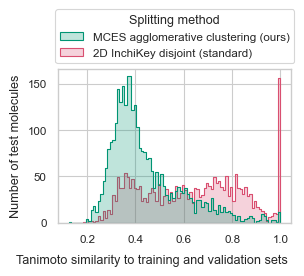

In [ ]:
utils.init_plotting(figsize=(3, 2))
ax = sns.histplot(df_plot[df_plot['Splitting method'] != 'Random'], x='max_train_tanimoto', hue='Splitting method', element="step", binwidth=0.01)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), frameon=True#ncol=3, title=None, frameon=False,
)
plt.xlabel('Tanimoto similarity to training and validation sets')
ax.xaxis.set_label_coords(0.4, -0.2)
plt.ylabel('Number of test molecules')
plt.savefig('splits.svg', bbox_inches='tight')
plt.show()

## Leakage examples

In [9]:
df_0 = df[df['smiles'] == 'CCCCCCCC(=O)CC(=O)NC1CCOC1=O']
df_1 = df[df['smiles'] == 'CCCCCC(=O)CC(=O)NC1CCOC1=O']

MassSpecGymID0063023 MassSpecGymID0062601


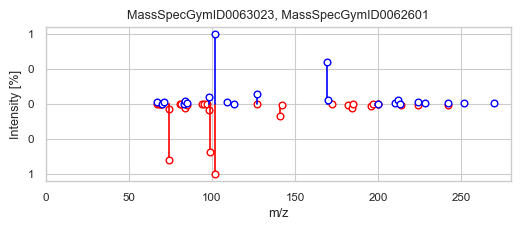

MassSpecGymID0063023 MassSpecGymID0062602


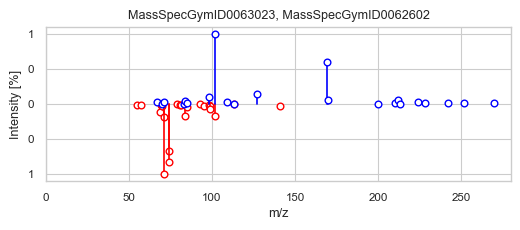

MassSpecGymID0063023 MassSpecGymID0062603


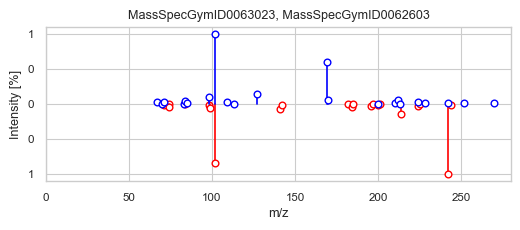

MassSpecGymID0063023 MassSpecGymID0062604


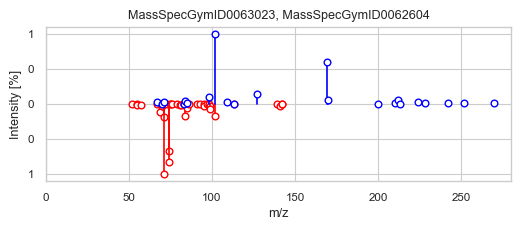

MassSpecGymID0063023 MassSpecGymID0062605


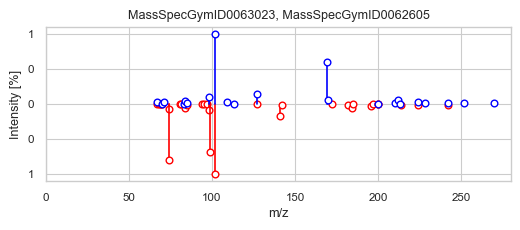

MassSpecGymID0063023 MassSpecGymID0062606


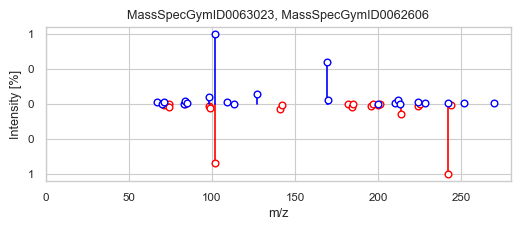

MassSpecGymID0063024 MassSpecGymID0062601


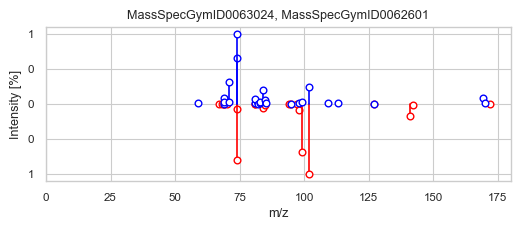

MassSpecGymID0063024 MassSpecGymID0062602


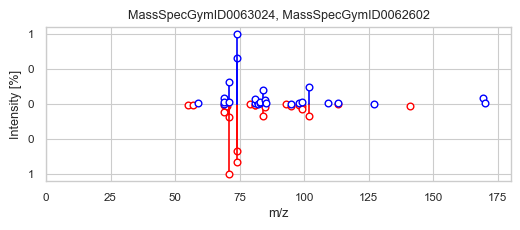

MassSpecGymID0063024 MassSpecGymID0062603


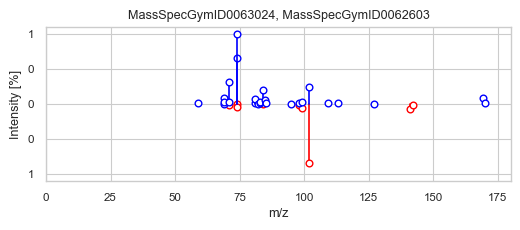

MassSpecGymID0063024 MassSpecGymID0062604


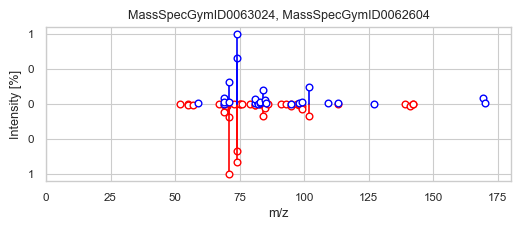

MassSpecGymID0063024 MassSpecGymID0062605


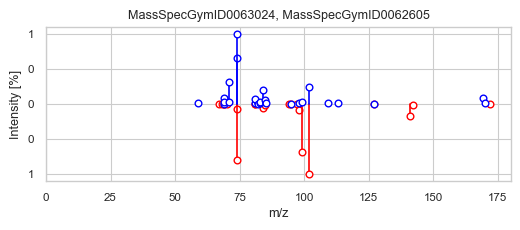

MassSpecGymID0063024 MassSpecGymID0062606


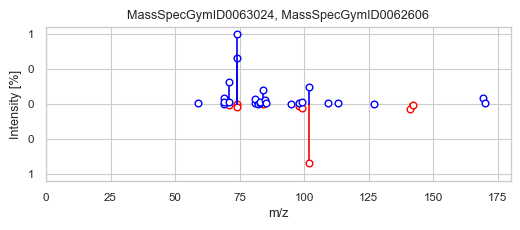

MassSpecGymID0063025 MassSpecGymID0062601


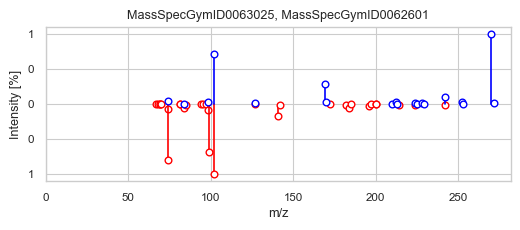

MassSpecGymID0063025 MassSpecGymID0062602


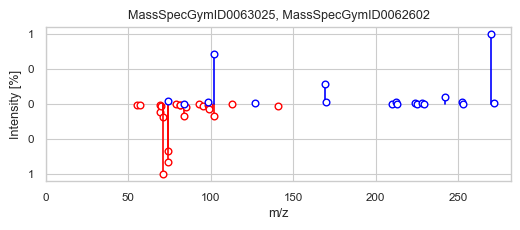

MassSpecGymID0063025 MassSpecGymID0062603


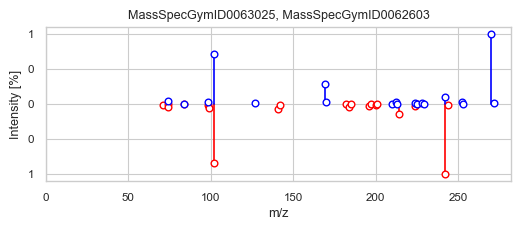

MassSpecGymID0063025 MassSpecGymID0062604


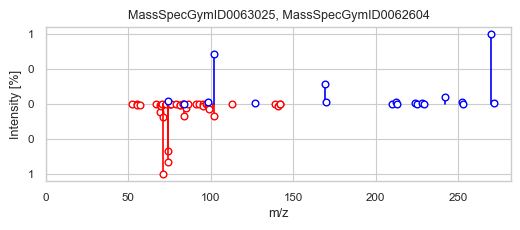

MassSpecGymID0063025 MassSpecGymID0062605


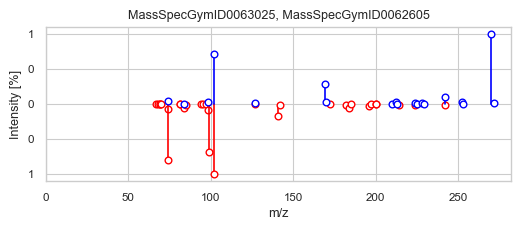

MassSpecGymID0063025 MassSpecGymID0062606


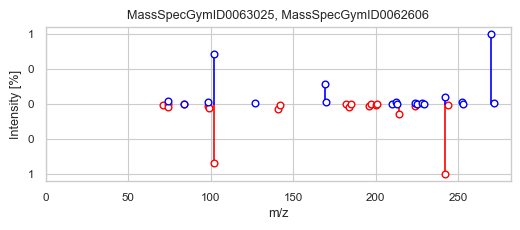

MassSpecGymID0063026 MassSpecGymID0062601


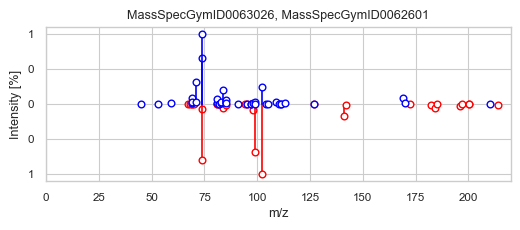

MassSpecGymID0063026 MassSpecGymID0062602


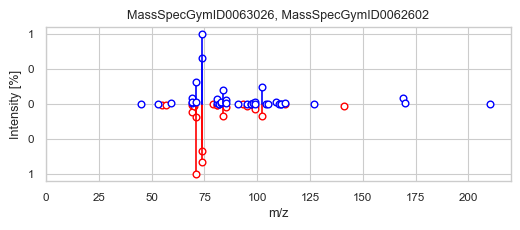

MassSpecGymID0063026 MassSpecGymID0062603


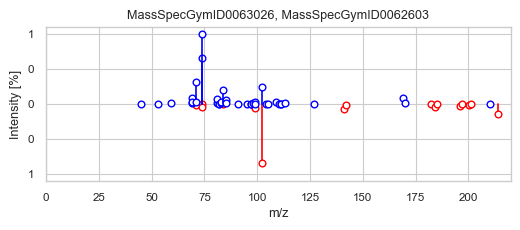

MassSpecGymID0063026 MassSpecGymID0062604


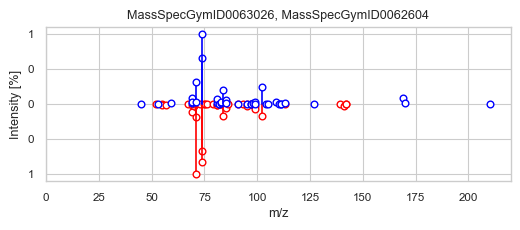

MassSpecGymID0063026 MassSpecGymID0062605


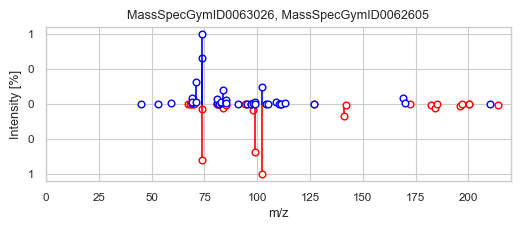

MassSpecGymID0063026 MassSpecGymID0062606


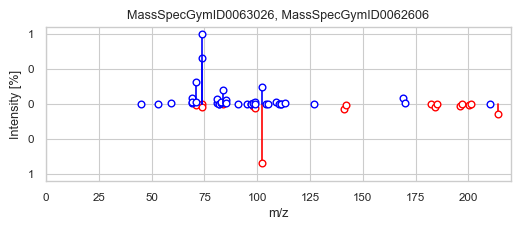

MassSpecGymID0063027 MassSpecGymID0062601


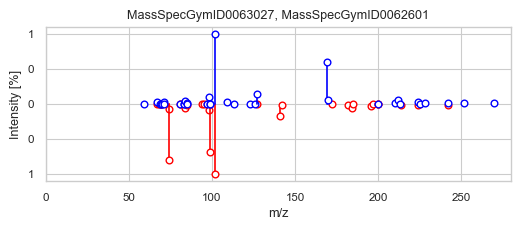

MassSpecGymID0063027 MassSpecGymID0062602


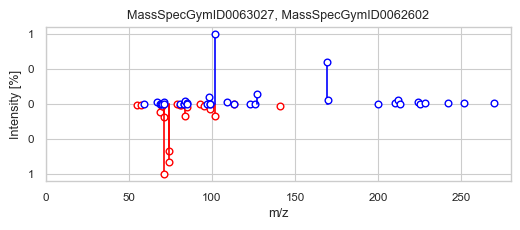

MassSpecGymID0063027 MassSpecGymID0062603


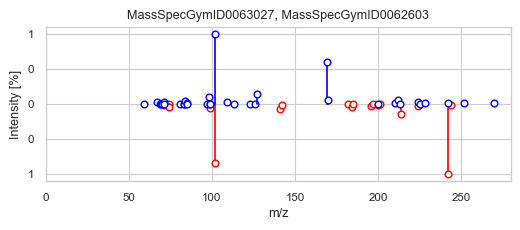

MassSpecGymID0063027 MassSpecGymID0062604


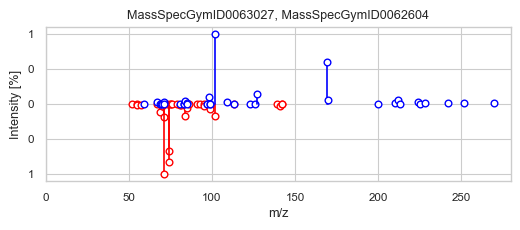

MassSpecGymID0063027 MassSpecGymID0062605


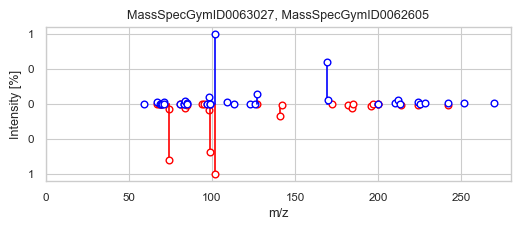

MassSpecGymID0063027 MassSpecGymID0062606


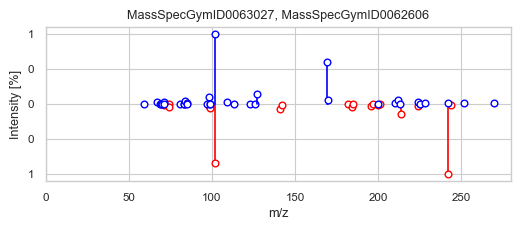

MassSpecGymID0063028 MassSpecGymID0062601


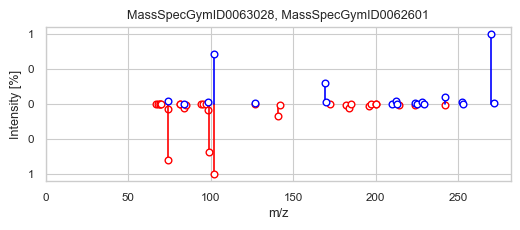

MassSpecGymID0063028 MassSpecGymID0062602


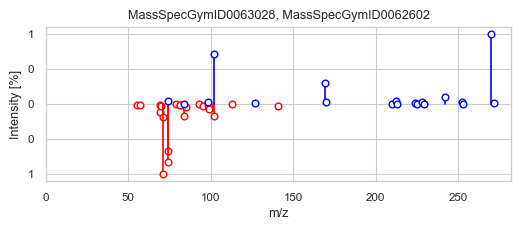

MassSpecGymID0063028 MassSpecGymID0062603


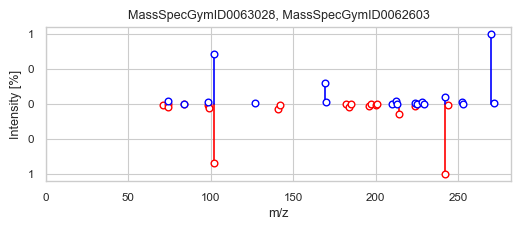

MassSpecGymID0063028 MassSpecGymID0062604


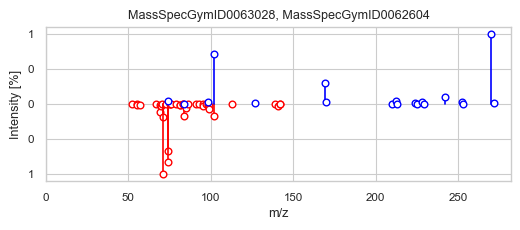

MassSpecGymID0063028 MassSpecGymID0062605


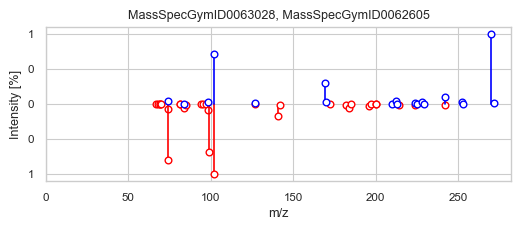

MassSpecGymID0063028 MassSpecGymID0062606


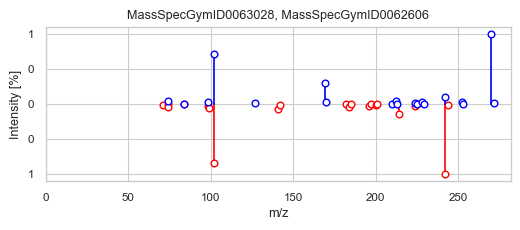

MassSpecGymID0063029 MassSpecGymID0062601


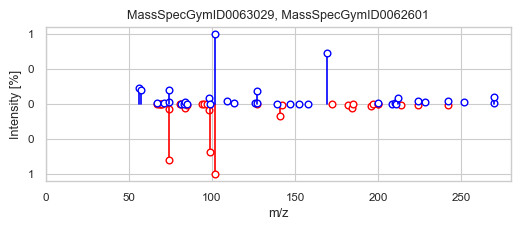

MassSpecGymID0063029 MassSpecGymID0062602


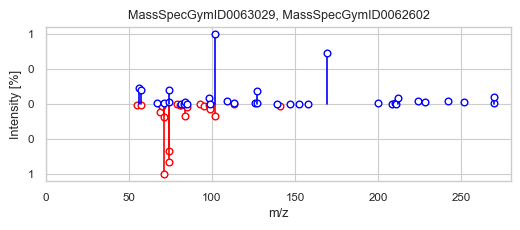

MassSpecGymID0063029 MassSpecGymID0062603


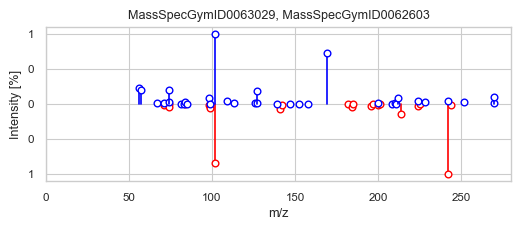

MassSpecGymID0063029 MassSpecGymID0062604


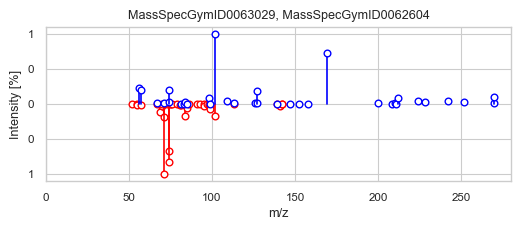

MassSpecGymID0063029 MassSpecGymID0062605


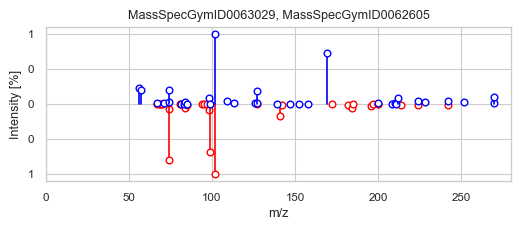

MassSpecGymID0063029 MassSpecGymID0062606


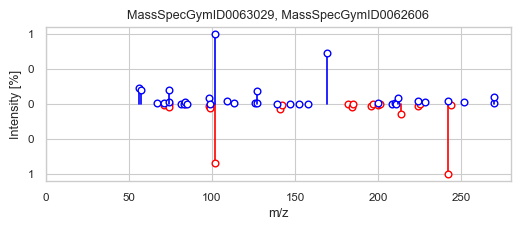

In [35]:
for (i, row_0), (j, row_1) in itertools.product(df_0.iterrows(), df_1.iterrows()):
    print(i, j)
    spec_0 = np.stack([utils.parse_spec_array(row_0['mzs']), utils.parse_spec_array(row_0['intensities'])])
    spec_1 = np.stack([utils.parse_spec_array(row_1['mzs']), utils.parse_spec_array(row_1['intensities'])])
    utils.plot_spectrum(spec_0, mirror_spec=spec_1)
    plt.title(f'{i}, {j}')
    plt.show()

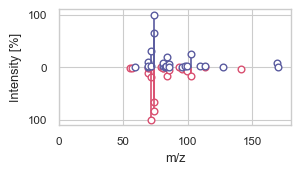

In [10]:
row_0 = df_0.loc['MassSpecGymID0063024']
row_1 = df_1.loc['MassSpecGymID0062602']
spec_0 = np.stack([utils.parse_spec_array(row_0['mzs']), utils.parse_spec_array(row_0['intensities'])])
spec_1 = np.stack([utils.parse_spec_array(row_1['mzs']), utils.parse_spec_array(row_1['intensities'])])
utils.plot_spectrum(spec_0, mirror_spec=spec_1, colors=["#5A5B9F", 'red', "#D94F70"], figsize=(3, 1.5))
plt.savefig('spectrum_example.svg', bbox_inches='tight')
plt.show()

In [15]:
smiles_0 = row_0['smiles']
print(smiles_0)
smiles_1 = row_1['smiles']
print(smiles_1)

CCCCCCCC(=O)CC(=O)NC1CCOC1=O
CCCCCC(=O)CC(=O)NC1CCOC1=O
